In [1]:
!pip install --user -U tensorflow-gpu==1.15.0 --force-reinstall 
!pip install -U --user numpy==1.19.0

  Using cached tensorflow_gpu-1.15.0-cp37-cp37m-win_amd64.whl (294.5 MB)
  Using cached absl_py-0.12.0-py3-none-any.whl (129 kB)
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached gast-0.2.2-py3-none-any.whl
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached protobuf-3.17.3-cp37-cp37m-win_amd64.whl (909 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached numpy-1.20.3-cp37-cp37m-win_amd64.whl (13.6 MB)
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Using cached wrapt-1.12.1-cp37-cp37m-win_amd64.whl
  Using cached grpcio-1.38.0-cp37-cp37m-win_amd64.whl (3.1 MB)
  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached six-1.16.0-py2.py3-none-

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.0
    Uninstalling numpy-1.19.0:
      Successfully uninstalled numpy-1.19.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.5.0
    Uninstalling importlib-metadata-4.5.0:
      Successfully uninstalled importlib-metadata-4.5.0
  Attempting uninstall: cached-property
    Found existing installation: cached-property 1.5.2
    Uninstalling cached-property-1.5.2:
      Successfully uninstalled cached-property-1.5.2
  Attempting uninstall: wheel
    Found existing installation: wheel 0.36.2
    Uninstalling wheel-0.36.2:
      Successfully uninstalled wheel-0.36.2
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 2.0.1
    Uninstalling Werkzeug-2.0.1:
      Successfully uninstalled Werkzeug-2.0.1
  Atte

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Guided Annotation tool - LSTM
This notebook shows you the whole process of preparing the data which is used as input in the guided annotation tool.
The tool basically shows unlabelled data in the form of explainable clusters to label.
It will show you the following steps:

    1. Load dataset
    2. Train a model and explain it - LSTM in this case
    3. Perform shap clustering
    4. Save the clusters to database with keywords to be highlighted by the annotation tool

In [1]:
import os
files = os.listdir("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.0/bin")
files = [i for i in files if i.endswith('.dll') and i.startswith('cu')]


In [2]:
import ctypes
for file in files:
    try:
        hllDll = ctypes.WinDLL("C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.0\\bin\\"+ file)
    except:
        pass



## 1. Install dependencies and imports

In [3]:
import json
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean, cosine

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score, v_measure_score, completeness_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
# import chart_studio.plotly as py
import seaborn as sns
import shap


from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score

pd.set_option('display.max_colwidth', 1000)

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6018178429046417338
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3186409472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17738458457878296517
physical_device_desc: "device: 0, name: Quadro M1200, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


### Built-in function usage
To avoid re-writing a lot of stuff for each dataset/model, I have created some functions in the models module/folder.
We are going to use this python module in this tutorial.

In [5]:
import os
os.getcwd()
os.chdir('../')
from models.trainers import Trainer
from app.utils import clear_labels
from models.guided_learning import GuidedLearner
pd.set_option('display.max_colwidth', 1000)

## 2.Download dataset

In [6]:
df = pd.read_csv('datasets/davidson_dataset.csv') # substitute other datasets in similar format
print(df.shape)
df.head(10)

(5233, 4)


,index,label,text,processed
0,1,0,as a woman you should not complain about cleaning up your house as a man you should always take the garbage out,as a woman you should not complain about cleaning up your house as a man you should always take the garbage out
1,2,0,momma said no cats inside my doghouse,momma said no cats inside my doghouse
2,3,0,simply addicted to guys hot scally lad,simply addicted to guys hot scally lad
3,4,0,and hot soles,and hot soles
4,5,0,lemmie eat a oreo do these dishes one oreo,lemmie eat a oreo do these dishes one oreo
5,6,0,why the eggplant emoji would he say she looked like scream,why the eggplant emoji would he say she looked like scream
6,7,0,baby monkey bathtime this is so adorable,baby monkey bathtime this is so adorable
7,8,0,baseball season for the win yankees this is where the love started,baseball season for the win yankees this is where the love started
8,9,0,i am an early bird and i am a night owl so i am wise and have worms,i am an early bird and i am a night owl so i am wise and have worms
9,10,0,overdosing on heavy drugs does not sound bad tonight i do that every day,overdosing on heavy drugs does not sound bad tonight i do that every day


In [7]:
df['label'].value_counts()

0    3857
1    1376
Name: label, dtype: int64

## 3. Define Model

In [8]:
x = df['text'].values
y = df['label'].values

In [9]:
indices =  np.random.randint(low=0, high=x.shape[0], size=x.shape[0])
train_indices = indices[0:round(0.8*x.shape[0])]
pool_indices = indices[round(0.8*x.shape[0]):]
df_train = df.iloc[train_indices]['text'].values
df_test = df.iloc[pool_indices]['text'].values
y_train = y[train_indices]
y_test = y[pool_indices]

In [10]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train)

X_train = tokenizer.texts_to_sequences(df_train)
X_test = tokenizer.texts_to_sequences(df_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print(df_train[2])
print(X_train[2])

 albert you pulled that queer shit as spon as you put no homo 
[2642, 4, 702, 11, 220, 175, 56, 2643, 56, 4, 198, 40, 703]


In [11]:
path_to_glove_file = "notebooks/glove.6B.300d.txt"


embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [12]:
max_features = vocab_size
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 4
n_epochs = 5
print('Loading data...')
(x_train, y_train), (x_test, y_test) = (X_train, y_train), (X_test, y_test)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
x_train = np.asarray(x_train).astype(np.float32)
y_train =np.asarray(y_train).astype(np.float32)
x_test =np.asarray(x_test).astype(np.float32)
y_test =np.asarray(y_test).astype(np.float32)
print('Build model...')
model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
history  = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=n_epochs,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
4186 train sequences
1047 test sequences
Pad sequences (samples x time)
x_train shape: (4186, 80)
x_test shape: (1047, 80)
Build model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train...
Train on 4186 samples, validate on 1047 samples
Epoch 1/5
4186/4186 [==============================] - 160s 38ms/sample - loss: 0.2579 - acc: 0.8966 - val_loss: 0.0945 - val_acc: 0.9694
Epoch 2/5
4186/4186 [==============================] - 155s 37ms/sample - loss: 0.0589 - acc: 0.9818 - val_loss: 0.1067 - val_acc: 0.9685
Epoch 3/5
4186/4186 [==============================] - 151s 36ms/sample - loss: 0.0218 - acc: 0.9928 - val_loss: 0.1055 - val_acc: 0.9771
Epoch 4/5
4186/4186 [==============================] - 213s 51ms/sample - loss: 0.0110 - acc: 0.9967 - val_loss: 0.1113 - val_acc: 0.9790
Epoch 5/5
1047/1047 [==============================] - 10s 9ms/sample - loss: 0.1444 - acc: 0.9761
Test score: 0.14439291991450695
Test accuracy: 0.97612226


In [ ]:
# Plot epochs vs train and test scores
# data = [go.Scatter(x=list(range(n_epochs)), y=homogeneity_scores, mode="lines", name="homogeneity"),


1047/1047 [==============================] - 2s 2ms/sample
Overall F1 Score 0.9576988155668359


<AxesSubplot:>

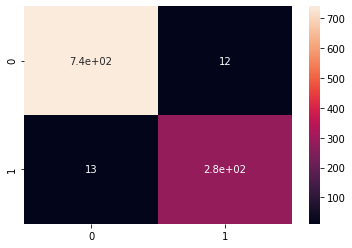

In [13]:
predictions = model.predict_classes(x_test, verbose=1)
print('Overall F1 Score', f1_score(predictions, y_test))
sns.heatmap(confusion_matrix(y_test, predictions),annot=True)

In [15]:
x_train.shape, x_test.shape

((4186, 80), (1047, 80))

### 4. Perform shap clustering
We are going to cluster the training data using SHAP explanations (shapely space)
SHAP clustering works by clustering on Shapley values of each instance. 
This means that you cluster instances by explanation similarity.

In [17]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:5000])



In [19]:
# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test[:100])

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[80,8372,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node lstm/TensorArrayStack/TensorArrayGatherV3 (defined at C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[gradients_1/embedding/embedding_lookup_grad/Select/_131]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[80,8372,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node lstm/TensorArrayStack/TensorArrayGatherV3 (defined at C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

Original stack trace for 'lstm/TensorArrayStack/TensorArrayGatherV3':
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\ipykernel\kernelapp.py", line 619, in start
    self.io_loop.start()
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\asyncio\base_events.py", line 541, in run_forever
    self._run_once()
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\asyncio\base_events.py", line 1786, in _run_once
    handle._run()
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\ipykernel\kernelbase.py", line 374, in dispatch_queue
    yield self.process_one()
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\tornado\gen.py", line 250, in wrapper
    runner = Runner(ctx_run, result, future, yielded)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\tornado\gen.py", line 741, in __init__
    self.ctx_run(self.run)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\ipykernel\kernelbase.py", line 358, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\ipykernel\kernelbase.py", line 538, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\IPython\core\interactiveshell.py", line 2899, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
    return runner(coro)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\IPython\core\interactiveshell.py", line 3170, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "c:\users\s164255\anaconda3\envs\explainableml\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-cec2411107a9>", line 22, in <module>
    model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.2))
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\sequential.py", line 195, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\layers\recurrent.py", line 623, in __call__
    return super(RNN, self).__call__(inputs, **kwargs)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\engine\base_layer.py", line 854, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\layers\recurrent.py", line 2549, in call
    inputs, mask=mask, training=training, initial_state=initial_state)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\layers\recurrent.py", line 756, in call
    zero_output_for_mask=self.zero_output_for_mask)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\backend.py", line 4057, in rnn
    outputs = tuple(o.stack() for o in output_ta)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\backend.py", line 4057, in <genexpr>
    outputs = tuple(o.stack() for o in output_ta)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\tensor_array_ops.py", line 1098, in stack
    return self._implementation.stack(name=name)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\tensor_array_ops.py", line 283, in stack
    return self.gather(math_ops.range(0, self.size()), name=name)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\tensor_array_ops.py", line 297, in gather
    element_shape=element_shape)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\gen_data_flow_ops.py", line 7103, in tensor_array_gather_v3
    element_shape=element_shape, name=name)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "C:\Users\s164255\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
shap_values[0][0].shape

In [ ]:
# Creating a reverse dictionary
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
shap.summary_plot(shap_values[0], x_test[:100], reverse_word_map)

In [ ]:
# transform the indexes to words
import numpy as np
# use number to words map to get x_test in form of words
num2word = reverse_word_map
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])



In [ ]:
index = 1
shap.force_plot(explainer.expected_value[0], shap_values[0][index], x_test_words[index], matplotlib=True), df_test[index]

In [ ]:
shap_values_pool = shap_values[0]
n_clusters = 20
kmeans = KMeans(n_clusters= n_clusters, n_jobs=-1, max_iter=600)
kmeans.fit(shap_values_pool)

In [ ]:
homogeneity_score( y_test[:1000], kmeans.labels_), v_measure_score(y_test[:1000], kmeans.labels_)